# Predictive analysis using Facebook Prophet and Olive™ EdgeROS

## Introduction
In this project, a ROS (Robot Operating System) node is employed, which subscribes to a topic that continuously publishes acceleration values. These values, reflective of the machine's activity, are meticulously logged into a CSV file, ensuring data integrity even after the node is shut down. This stored dataset serves as the foundational training data for the Prophet algorithm.

This Python script is tailored for predictive maintenance applications, specifically targeting the analysis and forecasting of vibration data from an Inertial Measurement Unit (IMU). Predictive maintenance aims to foresee potential equipment failures by analyzing data trends, thereby enabling timely maintenance and reducing downtime. By leveraging this dataset, Prophet—an open-source forecasting tool—becomes empowered to discern patterns and forecast future trends based on past acceleration values. This proactive approach allows for predictive maintenance strategies, enabling preemptive interventions to mitigate potential issues before they escalate.

Through seamless integration with ROS (Robot Operating System), this system not only ensures the real-time monitoring of machine health but also facilitates the efficient utilization of historical data to optimize predictive maintenance efforts. This holistic approach embodies the convergence of robotics, data analytics, and predictive maintenance methodologies to enhance operational efficiency and minimize downtime. The script reads and merges multiple data files, visualizes the vibration data, and uses the Prophet forecasting model to predict future vibrations, ultimately identifying anomalies that may indicate impending issues.

### Loading of data from a CSV file

In [1]:
import os
#os.chdir('')
print(" Current Working Directory")
%pwd

 Current Working Directory


'/home/ninad/AkzentE4.0/jupyternotebook'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [4]:
data_dir = './data_new'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    file_path = os.path.join(data_dir, filename)
    
    # Check if the current item is a file
    if os.path.isfile(file_path):
        dataset = pd.read_csv(file_path, header=0, index_col=[0])
        merged_data = merged_data.append(dataset)

print(merged_data)
print(merged_data.head(1))
print(merged_data.tail(1))


                     Acceleration
Timestamp                        
2024-05-16 13:37:45     10.024750
2024-05-16 13:37:51     11.610443
2024-05-16 13:37:52      7.334005
2024-05-16 13:37:53     10.069441
2024-05-16 13:37:54     14.182975
...                           ...
2024-05-16 14:29:33     10.969090
2024-05-16 14:29:34     14.568019
2024-05-16 14:29:35     10.436025
2024-05-16 14:29:36      6.529265
2024-05-16 14:29:37     10.991250

[2754 rows x 1 columns]
                     Acceleration
Timestamp                        
2024-05-16 13:37:45      10.02475
                     Acceleration
Timestamp                        
2024-05-16 14:29:37      10.99125


In [5]:
# Checking total points
print(f'Total Data Points {merged_data.shape[0] + 1}')

Total Data Points 2755


### Visualising the Data

In [6]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=merged_data, x='Timestamp', y='Acceleration', label='Vibration data', color='darkblue')
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=10000)) # Set interval higher if more data points
plt.xticks(rotation=90)
plt.title('Acceleration/vibration data')
plt.xlabel('Date/Time')
plt.ylabel('Vibration/Acceleration(m/s²)')
plt.legend()
plt.show()

In [7]:
healthy = merged_data.loc[:]  # Healthy dataset

### Anamoly detection using Prophet

Detecting anomalies in time series data involves identifying data points that deviate significantly from the expected or normal behavior of the system under observation. This is particularly important in machine health monitoring, where unexpected spikes or shifts in the data can indicate potential issues or deterioration in the machine's performance.

The task involves identifying outliers in the time series data that may signify anomalies such as sudden increases in vibration levels or persistent shifts in operational parameters. By analyzing deviations from the typical patterns of the machine's behavior, we can proactively identify potential issues before they escalate, enabling timely maintenance or intervention to prevent downtime or damage.

This approach to anomaly detection in time series data is crucial for ensuring the reliability, efficiency, and longevity of machines and equipment in various industrial and operational settings.

### Prophet:
Prophet is a versatile tool for time series forecasting, leveraging an additive model to capture non-linear trends and various seasonal patterns like yearly, weekly, and daily effects, alongside holiday impacts. It excels particularly in datasets showcasing pronounced seasonal variations and encompasses extensive historical data across multiple seasons. One of Prophet's notable strengths lies in its resilience to missing data and its ability to adapt to shifts in trends. Additionally, it demonstrates robust performance in handling outliers effectively. This makes Prophet a valuable asset for forecasting tasks across diverse domains, facilitating accurate predictions even in the presence of irregularities or abrupt changes in the data.

In [8]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

### Training data set
During the training phase of the anomaly detection model, data from the healthy phase of the bearing is utilized. When employing Prophet for this purpose, the input data should adhere to a specific format. It should be structured as a dataframe with two columns:

* ds (datestamp): This column should contain the timestamps corresponding to the measurements. The timestamps should ideally be in the format expected by Pandas, such as 'YYYY-MM-DD' for a date or 'YYYY-MM-DD HH:MM:SS' for a timestamp.

* y: This column should contain numeric values representing the measurements that we aim to forecast or analyze. These could be vibration levels, temperature readings, or any other relevant metrics indicative of the machine's health.

By adhering to this format, Prophet can effectively analyze the time series data and generate forecasts, facilitating the detection of anomalies or deviations from the expected behavior during the healthy phase of the bearing.

In [9]:
# Creating training dataframe
prophet_healthy_train = pd.DataFrame()
prophet_healthy_train['ds'] = healthy.index
prophet_healthy_train['y'] = healthy.values

## Creating the model: Calling the Prophet Module for training

In [10]:
m = Prophet(interval_width=1)
# Using healthy data for training
m.fit(prophet_healthy_train)

18:34:58 - cmdstanpy - INFO - Chain [1] start processing
18:34:58 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
forecast_healthy = m.predict(prophet_healthy_train)
forecast_healthy[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
2749 2024-05-16 14:29:33  10.144342    0.426618   18.723891
2750 2024-05-16 14:29:34  10.144505    0.548883   19.202754
2751 2024-05-16 14:29:35  10.144667    1.225671   19.541828
2752 2024-05-16 14:29:36  10.144830    1.372053   21.064271
2753 2024-05-16 14:29:37  10.144992    1.582191   20.253523

# Analysing the healthy data

Displaying Prophet plot


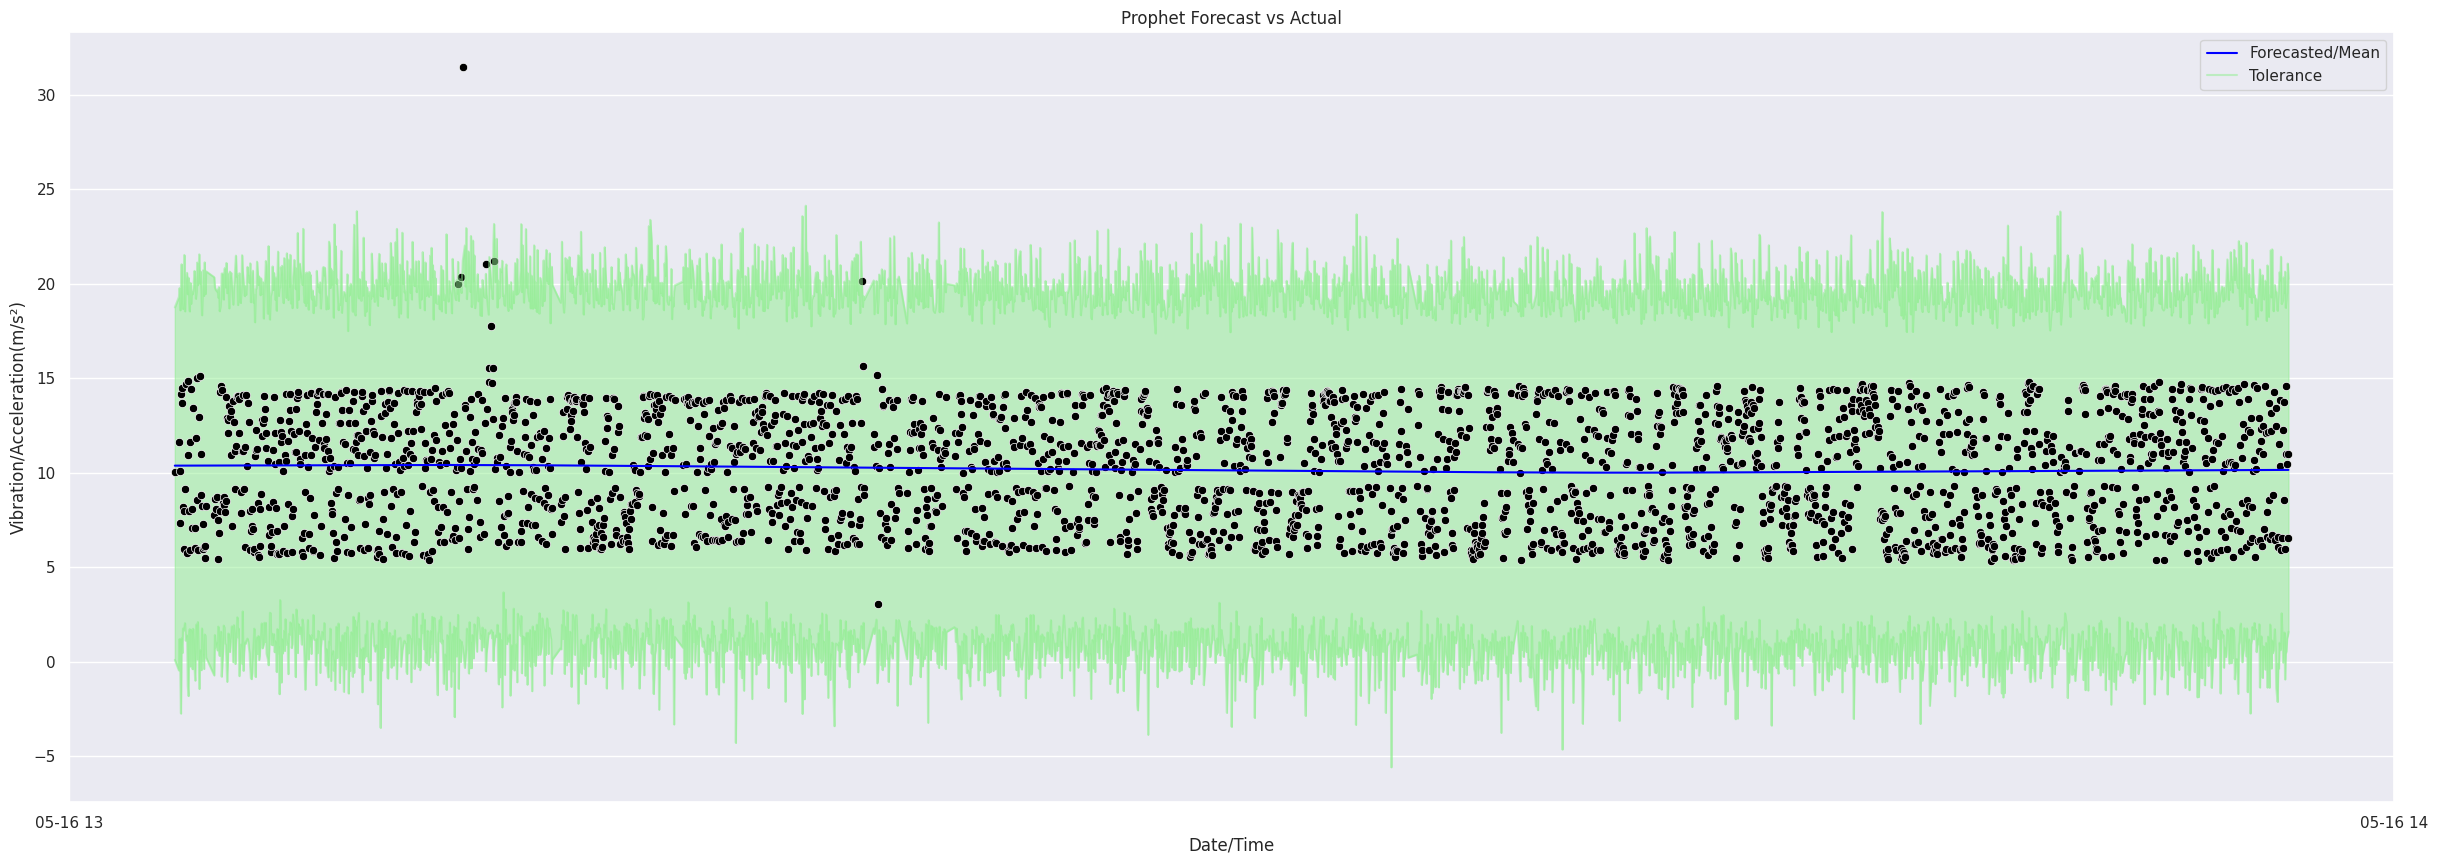

Black points are the true values from the IMU. Lightblue line is the trend line and the light green area is the tolerance.


In [12]:
forecast_healthy['fact'] = prophet_healthy_train['y'].reset_index(drop=True)
print('Displaying Prophet plot')

# Plotting the forecasted values
plt.figure(figsize=(30, 10))
sns.lineplot(data=forecast_healthy, x='ds', y='yhat', label='Forecasted/Mean', color='blue')

# Plotting the bounds
sns.lineplot(data=forecast_healthy, x='ds', y='yhat_lower', label='Tolerance', color='lightgreen', alpha=0.5)
sns.lineplot(data=forecast_healthy, x='ds', y='yhat_upper', color='lightgreen', alpha = 0.5)
plt.fill_between(forecast_healthy['ds'], forecast_healthy['yhat_lower'], forecast_healthy['yhat_upper'], color='lightgreen', alpha=0.5)

# Plotting the healthy values
#sns.lineplot(data=forecast_healthy, x='ds', y='fact', label='Actual', color='darkblue')
sns.scatterplot(data=forecast_healthy, x='ds', y='fact', color='black')

plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=100000))
plt.title('Prophet Forecast vs Actual')
plt.xlabel('Date/Time')
plt.ylabel('Vibration/Acceleration(m/s²)')
plt.legend()
plt.show()

print("Black points are the true values from the IMU. Lightblue line is the trend line and the light green area is the tolerance.")

### Predictions based on healthy values

In [13]:
future = m.make_future_dataframe(periods=120, freq="T") # Prediction for next five minutes
future.tail()

ds
2869 2024-05-16 16:25:37
2870 2024-05-16 16:26:37
2871 2024-05-16 16:27:37
2872 2024-05-16 16:28:37
2873 2024-05-16 16:29:37

In [14]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
2869 2024-05-16 16:25:37  11.276801    0.635387   22.189996
2870 2024-05-16 16:26:37  11.286558    1.203785   21.413081
2871 2024-05-16 16:27:37  11.296315    1.436640   21.901808
2872 2024-05-16 16:28:37  11.306072    1.609613   20.951596
2873 2024-05-16 16:29:37  11.315829    0.905046   22.930966

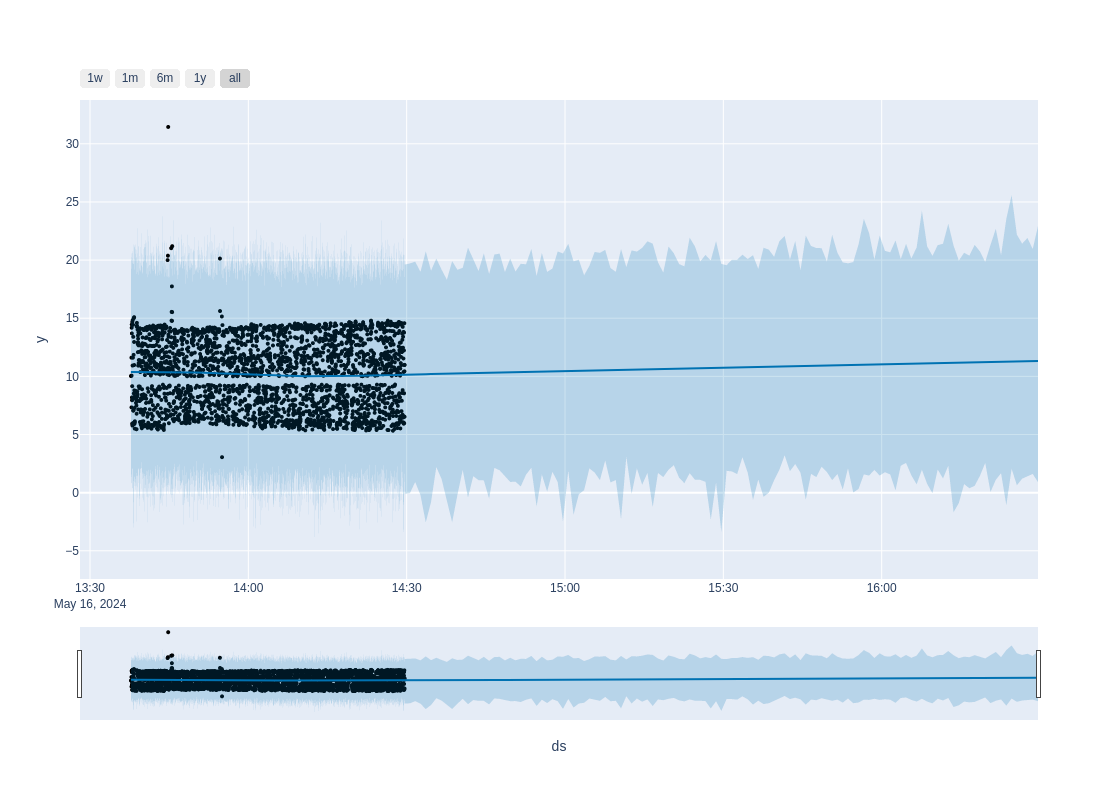

Black points are the actual healthy state values. Blue line describes the expected values and light blue area is the tolerance.


In [15]:
fig = plot_plotly(m, forecast)
fig.update_layout(width=1100, height=800)

fig2 = plot_components_plotly(m, forecast)
fig2.update_layout(width=1100, height=800)

fig.show()
print("Black points are the actual healthy state values. Blue line describes the expected values and light blue area is the tolerance.")

fig2.show()

## Summary

The script follows a structured approach to implement predictive maintenance:

* Environment Setup: Import necessary libraries and set plotting configurations for data visualization.
* Data Loading and Merging: Load vibration data from multiple CSV files, merge them into a single DataFrame for comprehensive analysis.
* Data Visualization: Generate initial plots of the vibration data to understand the historical trends and patterns.
* Prophet Model Training: Prepare the data for Prophet, fit the model, and forecast future values to predict the equipment's condition.
* Forecast Visualization: Plot the forecasted values, confidence intervals, and actual data to visually assess the model's performance and identify any anomalies.
* Future Predictions: Extend the forecast to predict future vibration data, aiding in early detection of potential issues.

## Conclusion

This script demonstrates a robust approach to predictive maintenance by analyzing and forecasting vibration data from an IMU. The use of the Prophet model facilitates accurate trend analysis and future predictions, providing a clear visualization of expected behavior and tolerance levels. By comparing actual data with forecasted values, the script effectively identifies deviations that may indicate impending equipment failures. This proactive monitoring system enables timely interventions, reduces unplanned downtime, and enhances overall equipment reliability.

## References
1. https://facebook.github.io/prophet/
2. https://www.olive-robotics.com/olive-imu